In [1]:
%matplotlib inline
# import packages
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sklearn as skl
import pytz
import statsmodels.api as sm
import zipline
import pathlib

# get api keys for binance 
import os
API_PUBLIC = os.environ.get("PUBLIC_KEY")
API_SECRET = os.environ.get("SECRET_KEY")
CSV_PATH_PREFIX = os.environ.get("PATH_TO_PROJECT")

In [2]:
# import data
df_hourly = {}
for key in os.listdir('hourly'):
    print(key[:-4]) # the weird slicing is to drop the .csv extension
    df_hourly[key[:-4]] = pd.read_csv('hourly/' + key)
    df_hourly[key[:-4]]['date'] = pd.to_datetime(df_hourly[key[:-4]]['date'])# ,unit='ms')
    df_hourly[key[:-4]].set_index('date', inplace=True)

ETHUSDT
BCHUSDT
BNBUSDT
BTCUSDT
XRPUSDT


In [2]:
# import data
df_minutely = {}
for key in os.listdir('minute'):
    print(key[:-4]) # the weird slicing is to drop the .csv extension
    df_minutely[key[:-4]] = pd.read_csv('minute/' + key)
    df_minutely[key[:-4]]['date'] = pd.to_datetime(df_minutely[key[:-4]]['date'])# ,unit='ms')
    df_minutely[key[:-4]].set_index('date', inplace=True)

ETHUSDT
BNBUSDT
BTCUSDT
XRPUSDT


In [3]:
for key in df_minutely:
    df_minutely[key].fillna(method="ffill", inplace=True)

In [9]:
df

{'ETHUSDT':                        open    high     low   close       volume
 date                                                            
 2019-11-28 10:00:00  152.30  152.31  149.82  151.13  29357.23936
 2019-11-28 11:00:00  151.11  151.81  150.77  151.57   9538.34518
 2019-11-28 12:00:00  151.59  151.60  150.19  150.79   8435.91551
 2019-11-28 13:00:00  150.77  151.41  150.45  151.02  11315.29199
 2019-11-28 14:00:00  151.03  151.25  150.41  150.89   6933.90227
 2019-11-28 15:00:00  150.89  154.63  150.75  153.99  32527.39597
 2019-11-28 16:00:00  153.97  154.02  152.79  153.84  16824.95914
 2019-11-28 17:00:00  153.83  153.97  153.15  153.52   5385.28789
 2019-11-28 18:00:00  153.50  154.17  153.27  153.34   5755.25411
 2019-11-28 19:00:00  153.34  154.22  153.27  153.69   5918.28565
 2019-11-28 20:00:00  153.69  154.23  152.06  152.06  11034.16930
 2019-11-28 21:00:00  152.06  152.52  151.33  151.90  10761.80048
 2019-11-28 22:00:00  151.89  152.59  150.03  150.22  10584.23538

In [4]:
# df = df_hourly
df = df_minutely

/home/joseph/miniconda3/envs/mscfe3/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


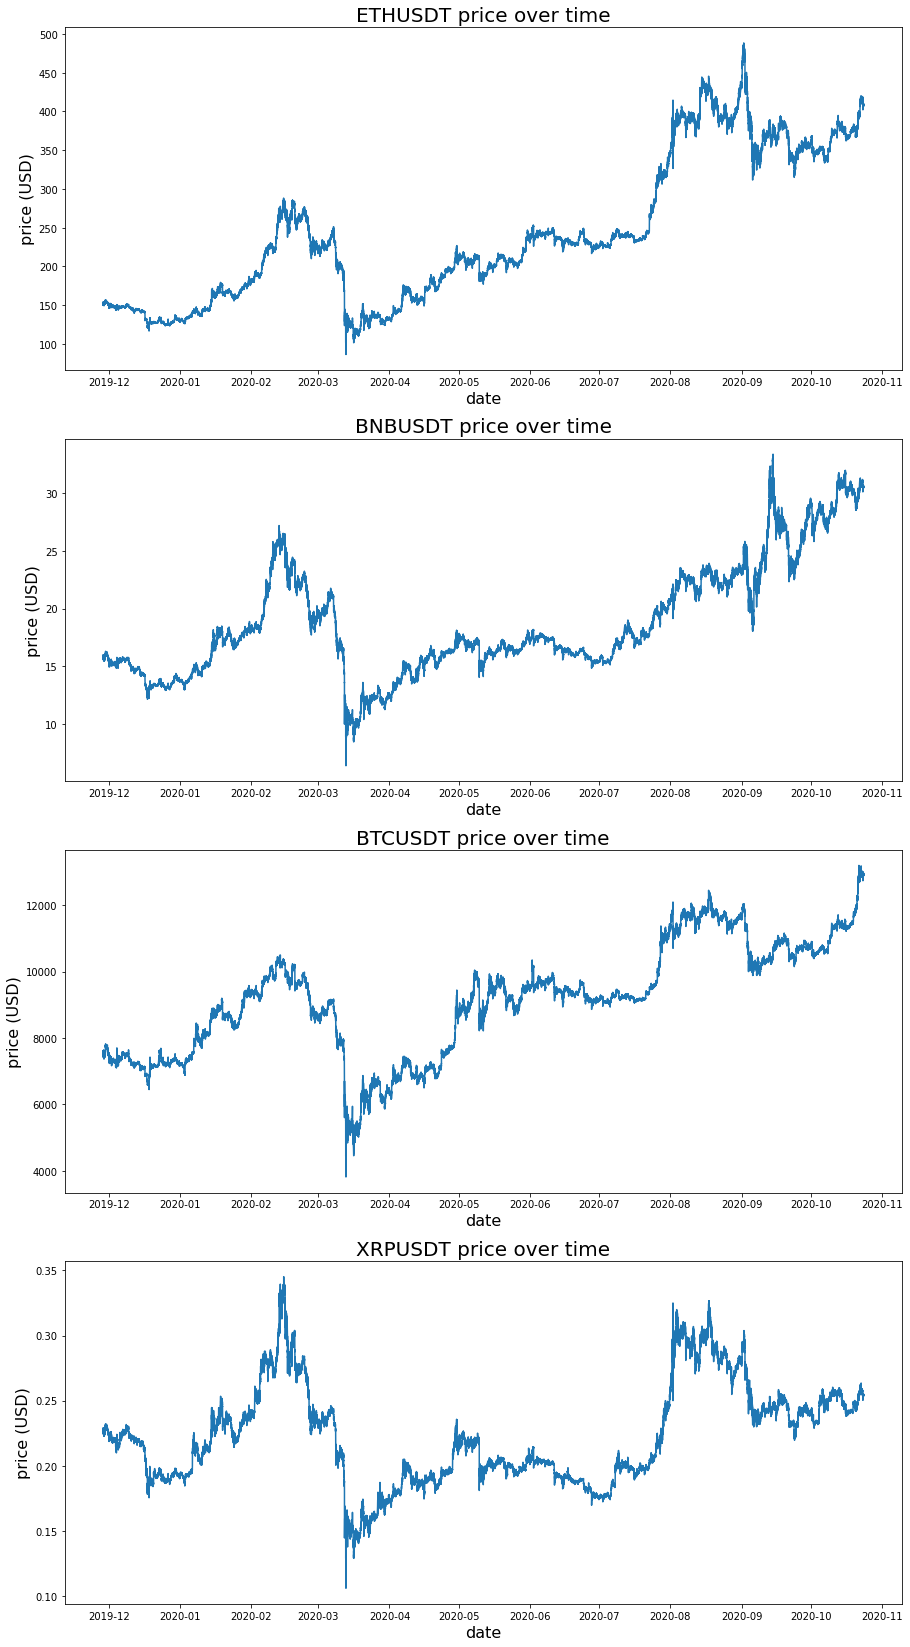

In [5]:
fig, ax = plt.subplots(len(df),figsize=(15, 29))

for i in range(len(df)):
    ax[i].plot(df[list(df.keys())[i]]['close']) # stacked plot of each of the currencies
    ax[i].set_title(list(df.keys())[i] + ' price over time',fontsize = 20) # set plot titles
    

# set axes lab%matplotlib inlineels
for i in range(len(df)):
    ax[i].set_xlabel('date',fontsize=16)
    ax[i].set_ylabel('price (USD)', fontsize=16)

In [6]:
# calculate correlations for closing prices of cryptocurrencies
df_cor = pd.DataFrame()
for key in df:
    #print(key)
    df_cor[key] = df[key]['close']

In [7]:
df_cor.corr()

,ETHUSDT,BCHUSDT,BNBUSDT,BTCUSDT,XRPUSDT
ETHUSDT,1.000000,0.181867,0.858195,0.921725,0.715937
BCHUSDT,0.181867,1.000000,0.344529,0.364336,0.670209
BNBUSDT,0.858195,0.344529,1.000000,0.845654,0.750167
BTCUSDT,0.921725,0.364336,0.845654,1.000000,0.760506
XRPUSDT,0.715937,0.670209,0.750167,0.760506,1.000000


highest correlation exists between BTC/ETH > BTC/BNB > XRP/ETH then BTC>XRP etc. Let's do pairs trading on BTC/ETH and BTC/BNB. BTC will be the explanatory variable in all regression analysis.

cointegration tests (incomplete but optional)

In [8]:
df_johansen = pd.DataFrame()
for key in df:
    df_johansen[key] = df[key]['close']

In [9]:
# we could screen through parameters det_order=[-1,0,1] and k_ar_diff=[0,1] using grid search when there's time
result = sm.tsa.var.vecm.coint_johansen(df_johansen,0,1)

LinAlgError: SVD did not converge

perform feature scaling

In [10]:
df_scaled=pd.DataFrame()
for key in df:
    df_scaled[key] = (df[key]['close'] - df[key]['close'].mean()) / df[key]['close'].std()

model spread using linear regression: $\mathrm{ETHUSDT} = \beta \times \mathrm{BTCUSDT} + \mathrm{const.} $

In [18]:
Y = df_scaled['ETHUSDT']
X = df_scaled['BTCUSDT']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

MissingDataError: exog contains inf or nans

## zipline for backtesting the strategy

In [6]:
%load_ext zipline

In [28]:
%%bash
zipline bundles
# datasets available

csvdir <no ingestions>
quandl <no ingestions>
quantopian-quandl <no ingestions>


In [24]:
start_session = pd.Timestamp('2019-11-28', tz='utc')
end_session = pd.Timestamp('2020-10-24', tz='utc')


In [9]:
from trading_calendars import register_calendar
from trading_calendars.always_open import AlwaysOpenCalendar

In [10]:
CSV_PATH_PREFIX;
CSV_PATH = pathlib.Path(CSV_PATH_PREFIX+'/submission_3/data-ideas/')

In [66]:

import pandas as pd

from zipline.data.bundles import register
from zipline.data.bundles.csvdir import csvdir_equities

register(
    'mscfe3_binance_24102020',
    csvdir_equities(
        ['minute'],
        '.',
    ),
    calendar_name='24/7', # 24/7 markets
    minutes_per_day=1440, 
    start_session=start_session,
    end_session=end_session
)

/home/joseph/miniconda3/envs/mscfe3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Overwriting bundle with name 'mscfe3_binance_24102020'
  from ipykernel import kernelapp as app


<bound method CSVDIRBundle.ingest of <zipline.data.bundles.csvdir.CSVDIRBundle object at 0x7f2609ebf128>>

In [67]:
zipline.data.bundles.ingest('mscfe3_binance_24102020')

 | BCHUSDT: sid 0
 | BNBUSDT: sid 1
 | BTCUSDT: sid 2
 | ETHUSDT: sid 3
 | XRPUSDT: sid 4


In [63]:
from zipline.api import order, record, symbol, set_benchmark
from datetime import datetime


def initialize(context):
    set_benchmark(symbol("BTCUSDT"))

def handle_data(context, data):
    order(symbol("BNBUSDT"), 10)
    record(BTC=data.current(symbol('BNBUSDT'), 'price'))

perf = zipline.run_algorithm(start=datetime(2020, 1, 1, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2020, 10, 20, 0, 0, 0, 0, pytz.utc), data_frequency='minute',
                      initialize=initialize,
                      capital_base=100000,
                      handle_data=handle_data, bundle='mscfe3_binance_24102020')

KeyError: Timestamp('2019-11-28 00:00:00+0000', tz='UTC')

everything below here doesn't work

In [ ]:
%%bash
zipline ingest -b 'mscfe3_binance_24102020'
# this is what you would run in a bash shell. 

In [ ]:
panel = pd.Panel(df)
panel.minor_axis = ["open","high","low","close","volume"]
#panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

In [78]:
help(zipline.run_algorithm)

Help on function run_algorithm in module zipline.utils.run_algo:

run_algorithm(start, end, initialize, capital_base, handle_data=None, before_trading_start=None, analyze=None, data_frequency='daily', bundle='quantopian-quandl', bundle_timestamp=None, trading_calendar=None, metrics_set='default', benchmark_returns=None, default_extension=True, extensions=(), strict_extensions=True, environ=environ({'XDG_SEAT_PATH': '/org/freedesktop/DisplayManager/Seat0', 'XDG_CONFIG_DIRS': '/etc/xdg/xdg-xubuntu:/usr/share/upstart/xdg:/etc/xdg:/etc/xdg', 'SESSION': 'xubuntu', 'XDG_RUNTIME_DIR': '/run/user/1000', 'SHLVL': '1', 'XDG_VTNR': '7', 'LOGNAME': 'joseph', 'LANGUAGE': 'en_GB:en', 'MANDATORY_PATH': '/usr/share/gconf/xubuntu.mandatory.path', 'GNOME_KEYRING_PID': '', 'UPSTART_INSTANCE': '', 'TERM': 'xterm-color', 'CLUTTER_IM_MODULE': 'xim', 'LANG': 'en_GB.UTF-8', 'QT_LINUX_ACCESSIBILITY_ALWAYS_ON': '1', 'COLORTERM': 'xfce4-terminal', 'GTK_IM_MODULE': 'xim', 'JOB': 'dbus', 'XDG_SESSION_ID': 'c2', 'X

In [106]:
zipline.data.bundles.bundles

mappingproxy({'quandl': RegisteredBundle(calendar_name='NYSE', start_session=None, end_session=None, minutes_per_day=390, ingest=<function quandl_bundle at 0x7f403f7b7f28>, create_writers=True),
              'quantopian-quandl': RegisteredBundle(calendar_name='NYSE', start_session=None, end_session=None, minutes_per_day=390, ingest=<function quantopian_quandl_bundle at 0x7f403f7c1158>, create_writers=False),
              'csvdir': RegisteredBundle(calendar_name='NYSE', start_session=None, end_session=None, minutes_per_day=390, ingest=<function csvdir_bundle at 0x7f403f7c1268>, create_writers=True)})

In [90]:
%load_ext zipline
# import zipline
#%load_ext zipline
from zipline.api import order, record, symbol, set_benchmark
from datetime import datetime


def initialize(context):
    pass
    # set_benchmark(symbol("SPY"))

def handle_data(context, data):
    order(symbol("BTCUSDT"), 10)
    record(SPY=data.current(symbol('BTCUSDT'), 'price'))

perf = zipline.run_algorithm(start=datetime(2020, 1, 1, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2020, 10, 20, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      capital_base=100000,
                      handle_data=handle_data, bundle=panel)

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


TypeError: 'Panel' objects are mutable, thus they cannot be hashed

## Plotting the spread; early examples

pairs trading on XRP/BTC pair

In [16]:
# calculate spread on mBTC/XRP pair on adjusted close
# should do regression and correlation analysis first
df_spread = df['BTCUSDT']['close']/10000. - df['XRPUSDT']['close']

/home/joseph/miniconda3/envs/mscfe3/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


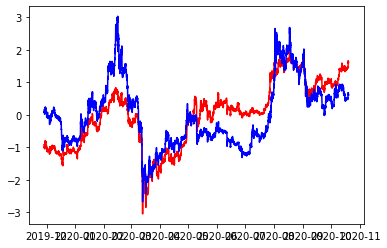

In [60]:
# plot price of symbols to get an idea of scaling
plt.plot(df_scaled['BTCUSDT'], color = 'red')
plt.plot(df_scaled['XRPUSDT'], color = 'blue')

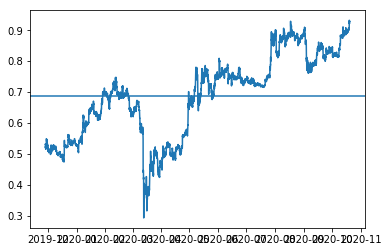

In [17]:
# plot spread
plt.plot(df_spread)
plt.axhline(df_spread.mean());